# Introduction to ehrapy

Welcome to ehrapy! 


ehrapy is a framework for the exploratory and targeted end-to-end analysis of complex electronic health record (EHR) datasets inspired by the biological omics world.
Hereby, data points are not necessarily treated as complete patients, but as patient visits representing snapshots of the underlying system.
The goal of any exploratory analysis not necessarily is to predict or classify a specific state, but to understand the system underlying the data manifold.

ehrapy is not a pure machine learning library or a pure statistics library, but a framework providing simplified access to fundamental algorithms to preprocess, visualize and analyze EHR data.

## Fundamental Principles

One of the main advantages of ehrapy is that EHR datasets can be analyzed from beginning to end with a clear, but flexible, order of operations.

![](images/ehrapy_overview.png)

ehrapy borrows a lot from the single-cell world and the [scverse](https://github.com/scverse/) ecosystem. Notably, ehrapy is using a data structure ([EHRData](https://ehrdata.readthedocs.io/en/latest/)) that is building on the central data structure in scverse ([AnnData](https://anndata.readthedocs.io/en/latest/)), leveraging its performant features. Further, ehrapy leverages fundamental algorithms within scverse (scanpy). Both are briefly introduced in the following subsections.

## EHRData

[EHRData](https://ehrdata.readthedocs.io/en/latest/) is short for Electronic Health Record Data, and is the primary data structure used within ehrapy. Technically described, it is a Python package for handling flat and longidutinal data arrays in memory and on disk, positioned between Pandas and xarray. EHRData offers a broad range of computationally efficient features including, among others, sparse data support, lazy operations, and a PyTorch interface. From a users perspective, it is based on the idea of a primary 2D or 3D matrix `X` of, for example, dimensions `n_patient_visits x n_features`, or `n_patient_visits x n_features x n_timepoints`. The individuals would then be the observations (`obs`) and the features would be the variables (`var`), and the timepoints the time axis (`tem`). EHRData allows us to annotate this array with respect to the observations, variables, and the time. Furthermore, EHRData allows for the addition of graph like structures (`obsp, varp`) and further structured (`obsm, varm`) and unstructured matrices (`uns`) to be saved within the same object. These can than be readily used for various machine learning algorithms.

More arrays in the shape of the central data array `X` can be stored in the `.layers` field. This is handy to keep track of e.g. differently processed data.

Importantly,
- all data in `.layers` must match the shape of `X`, or be 2 dimensional
- At the moment, `X` can only be 2 dimensional, while arrays in `layers` can be 2 and 3 dimensional.

Visualized it looks like this:


![](images/ehrdata_schema.png)

Let us create an example EHRData object as it would be used in ehrapy.

In [1]:
import pandas as pd

After importing the required packages, we create an example dataset with a **patient_visit_id** column and some feature columns such as **age**, **b12_level** and **d3_level**. We further add a **service_unit** column that we do not want to include as data for our algorithms, but only as annotations.

In [2]:
data = {
    "patient_visit_id": [0, 1, 2],
    "age": [59, 24, 64],
    "b12_level": [560, 201, 450],
    "d3_level": [25, 19, 50],
    "service_unit": ["NY", "NY", "BO"],
}
df = pd.DataFrame(data)

In [3]:
df

,patient_visit_id,age,b12_level,d3_level,service_unit
0,0,59,560,25,NY
1,1,24,201,19,NY
2,2,64,450,50,BO


Note that it has a `index_column` parameter to set the index and a `columns_obs_only` parameter which denotes features which should not be a part of the `X` matrix but of `obs` annotations. This will allow us to e.g. color plots by `service_unit`, but not to use these values for algorithms.

In [4]:
import ehrdata as ed

In [6]:
edata = ed.io.from_pandas(df, index_column="patient_visit_id", columns_obs_only=["service_unit"])

In [7]:
edata

EHRData object with n_obs × n_vars = 3 × 3
    obs: 'service_unit'
    shape of .X: (3, 3)

When examining our EHRData object we notice that it has a matrix of size 3 x 3 which correspond to our **age**, **B12** and **D3** measurements.

In [8]:
edata.obs

,service_unit
patient_visit_id,
0,NY
1,NY
2,BO


Furthermore, our `obs` has the service unit as expected. The EHRData object also has data in the `uns` (unstructured) slot that denotes which columns are numerical columns and which ones are not. This may be required for specific algorithms.

In [9]:
edata.uns

OrderedDict()

Finally, the `layers` slot of our object saves all original values before any modifications in `original`. When using ehrapy, the `X` matrix will constantly be modified when applying algorithms to the object (e.g. scaling). This layer is a copy of our original `X` which will allow us to e.g. scale the age, but use the original values when coloring a UMAP plot.

In [14]:
edata.layers["raw_data"] = edata.X.copy()
edata.layers["raw_data"]

array([[ 59., 560.,  25.],
       [ 24., 201.,  19.],
       [ 64., 450.,  50.]])

For more details please examine the [EHRData documentation](https://ehrdata.readthedocs.io/en/latest/index.html).

## scanpy

![](images/scanpy.jpg)


The documentation of ehrapy tries to hide as many details from the single-cell world as possible, but you may see the terms cell, gene or expression pop up somewhere. However, the tight integration of AnnData and EHRData and scanpy into ehrapy also allows for the joint analysis of omics data and EHR data. We will provide a vignette for this in the future.

To learn more about scanpy please read the [scanpy documentation ](https://scanpy.readthedocs.io/en/stable/) and the [scanpy paper ](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0).

## ehrapy

Now that we've covered the basics of EHRData and scanpy and we have an example dataset, we can apply some of ehrapy's tools on it.
We will start by calculating and visualizing a PCA on our data.

In [15]:
import ehrapy as ep
ep.pp.pca(edata)

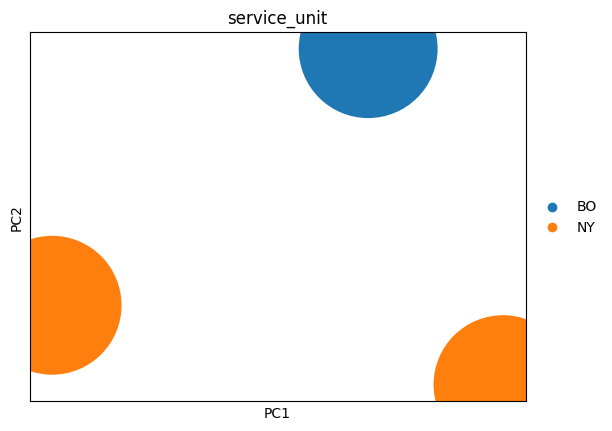

In [16]:
ep.pl.pca(edata, color="service_unit")

This is of course not a useful analysis since we only have three visits.

## Making your dataset ready for ehrapy

### Data types

ehrapy can work with two dimensional data as for example in a Pandas DataFrame, where a column stands for a variable, and a row for an observation.

ehrapy can also work with three dimensional data; see the [Getting Started with EHRData Tutorial](https://ehrdata.readthedocs.io/en/latest/tutorials/getting_started.html) on `ehrdata` for more details of what data formats are ready to go.

In [17]:
# This is NOT okay
data = {
    "MixedColumn1": ["Apple", 10, "Banana", 20],
    "MixedColumn2": [15, "Cherry", 5, "Date"],
}
df = pd.DataFrame(data)
df

,MixedColumn1,MixedColumn2
0,Apple,15
1,10,Cherry
2,Banana,5
3,20,Date


In [18]:
# This is okay
data = {
    "Column1": ["Apple", "Banana", "Cherry", "Date"],
    "Column2": [10, 20, 15, 5],
    "Column3": [True, False, True, False],
    "Column4": [
        pd.Timestamp("2023-08-01"),
        pd.Timestamp("2023-08-15"),
        pd.Timestamp("2023-08-10"),
        pd.Timestamp("2023-08-05"),
    ],
    "Column5": pd.Categorical(["dead", "alive", "dead", "dead"]),
}

df = pd.DataFrame(data)
df

,Column1,Column2,Column3,Column4,Column5
0,Apple,10,True,2023-08-01,dead
1,Banana,20,False,2023-08-15,alive
2,Cherry,15,True,2023-08-10,dead
3,Date,5,False,2023-08-05,dead


In [21]:
edata = ed.io.from_pandas(df)
ed.infer_feature_types(edata)
edata

! Feature  was detected as categorical features stored numerically.Please verify and adjust if necessary using `ed.replace_feature_types`.


 Detected feature types for EHRData object with 4 obs and 5 vars
╠══ 📅 Date features
║   ╚══ Column4
╠══ 📐 Numerical features
║   ╚══ Column2
╚══ 🗂️ Categorical features
    ╠══ Column1 (4 categories)
    ╠══ Column3 (2 categories)
    ╚══ Column5 (2 categories)

EHRData object with n_obs × n_vars = 4 × 5
    var: 'feature_type'
    shape of .X: (4, 5)

### Feature groups

For many analyses with ehrapy it is useful to group together features that belong to the same data modality.
Examples are high level groups such as demography values, lab or vital sign measurements.
This allows for simpler groupbys or the creation of subsets:

In [23]:
data = {
    "gender": pd.Categorical(["male", "female", "female", "male"]),
    "age": [10, 20, 15, 5],
    "b12": [300, 600, 800, 500],
    "d3": [25, 30, 28, 21],
}
df = pd.DataFrame(data)
df

,gender,age,b12,d3
0,male,10,300,25
1,female,20,600,30
2,female,15,800,28
3,male,5,500,21


In [25]:
edata = ed.io.from_pandas(df)
ed.infer_feature_types(edata)
edata.var

! Feature  was detected as categorical features stored numerically.Please verify and adjust if necessary using `ed.replace_feature_types`.


 Detected feature types for EHRData object with 4 obs and 4 vars
╠══ 📅 Date features
╠══ 📐 Numerical features
║   ╠══ age
║   ╠══ b12
║   ╚══ d3
╚══ 🗂️ Categorical features
    ╚══ gender (2 categories)

,feature_type
gender,categorical
age,numeric
b12,numeric
d3,numeric


In [26]:
demographics_features = ["age", "gender"]
lab_measurements_features = ["b12", "d3"]

# Assign the measurement groups to features in .var
measurement_group = []

for feature in edata.var_names:
    if feature in demographics_features:
        measurement_group.append("demographics")
    elif feature in lab_measurements_features:
        measurement_group.append("lab_measurements")

edata.var["measurement_group"] = measurement_group

In [27]:
edata_demographics = edata[:, edata.var["measurement_group"] == "demographics"]
edata_demographics

View of EHRData object with n_obs × n_vars = 4 × 2
    var: 'feature_type', 'measurement_group'
    shape of .X: (4, 2)

### Units

EHR measurements are recorded in specific units that are ideally stored with the measurements:

In [28]:
data = {
    "gender [categorical]": pd.Categorical(["male", "female", "female", "male"]),
    "age [years]": [10, 20, 15, 5],
    "b12 [pg/mL]": [300, 600, 800, 500],
    "d3 [ng/mL]": [25, 30, 28, 21],
}
df = pd.DataFrame(data)
df

,gender [categorical],age [years],b12 [pg/mL],d3 [ng/mL]
0,male,10,300,25
1,female,20,600,30
2,female,15,800,28
3,male,5,500,21


In [31]:
edata = ed.io.from_pandas(df)
ed.infer_feature_types(edata)

# Extract feature names and units from var_names and store separately
feature_names = [var_name.split("[")[0].strip() for var_name in edata.var_names]
unit_annotations = [var_name.split("[")[-1][:-1] if "[" in var_name else "" for var_name in edata.var_names]

# Update .var with feature names and units separately
edata.var_names = feature_names
edata.var["units"] = unit_annotations

! Feature  was detected as categorical features stored numerically.Please verify and adjust if necessary using `ed.replace_feature_types`.


 Detected feature types for EHRData object with 4 obs and 4 vars
╠══ 📅 Date features
╠══ 📐 Numerical features
║   ╠══ age 
║   ╠══ b12 
║   ╚══ d3 
╚══ 🗂️ Categorical features
    ╚══ gender  (2 categories)

In [32]:
edata.var

,feature_type,units
gender,categorical,categorical
age,numeric,years
b12,numeric,pg/mL
d3,numeric,ng/mL


In [33]:
d3_unit = edata.var["units"]["d3"]
print(f"Unit of 'd3': {d3_unit}")

Unit of 'd3': ng/mL


## Conclusion

To get started check out the [MIMIC-II introduction tutorial](https://ehrapy.readthedocs.io/en/latest/tutorials/mimic_2_introduction.html) where you will learn to apply ehrapy to a real dataset to investigate the effect of intdwelling artherical catheters on patient survival over multiple notebooks.

Please also consider consulting the [ehrapy API](https://ehrapy.readthedocs.io/en/latest/usage/usage.html) documentation.